### Avance 4
#### Baseline

Estudiantes:

- Carlos Alberto Reynoso Gonzalez. A01793188
- Israel Campos

En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.
 

Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa. 
Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.
 

Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
Curva ROC
Matriz de confusión
Curva de Precisión-Recall
Análisis de residuos
Gráfico de importancia de características
Tendencia y predicción (para series temporales)
Diagrama de árbol (para árboles de decisión)

#### Desarrollo

Los modelos mas relevantes de la afse entior fueron la red U-net y U-net++.
Antes de iniciar con el ensamble homogeneo y heterogeneo se cargas las cosas necesarias.

In [ ]:

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader, random_split
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Se importan los modelos y la clase de base de datos

In [2]:
from torch_db import StressDataset
from models import UNet,UNetPlusPlus # los modelos a probar se importas del archivo models.py de este mismo repositorio

se importa la data

In [3]:


# Path to the root folder containing subfolders
root_folder = "db/"

# Define transformations (e.g., resize images, normalize them, etc.)
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 128x128 pixels
    transforms.ToTensor()          # Convert to a PyTorch tensor
])

# Create an instance of the dataset
dataset = StressDataset(root_folder=root_folder, transform=transform_pipeline)



db/hstrips\1
db/hstrips\10
db/hstrips\2
db/hstrips\3
db/hstrips\4
db/hstrips\5
db/hstrips\6
db/hstrips\7
db/hstrips\8
db/hstrips\9
db/random\1
db/random\10
db/random\11
db/random\12
db/random\13
db/random\14
db/random\15
db/random\16
db/random\17
db/random\18
db/random\19
db/random\2
db/random\20
db/random\21
db/random\22
db/random\23
db/random\24
db/random\25
db/random\26
db/random\27
db/random\28
db/random\29
db/random\3
db/random\30
db/random\4
db/random\5
db/random\6
db/random\7
db/random\8
db/random\9
db/vstrips\31
db/vstrips\32
db/vstrips\33
db/vstrips\34
db/vstrips\35
db/vstrips\36
db/vstrips\37
db/vstrips\38
db/vstrips\39
db/vstrips\40
db/vstrips\41


Para observar y confirmar la correcta importancion, visualizamos las matrices. A la izquierda esta la matriz de entrada y a la derecha la de salida que buscaremos predicr a traves del modelo

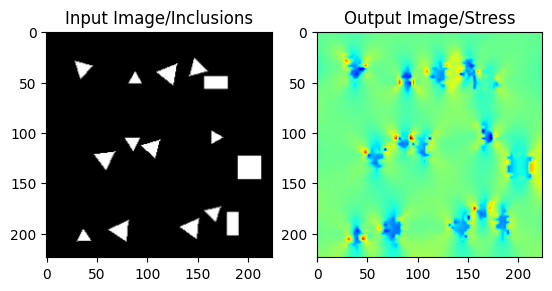

min 73.16007995605469 , avg 125.22615051269531 , max 183.36460876464844


In [4]:

i=6
in_=dataset[i][0][0,:,:]
out=dataset[i][1][0,:,:]
#plot 2x1 grid
fig, axs = plt.subplots(1, 2)
axs[0].imshow(in_, cmap='gray')
axs[0].set_title('Input Image/Inclusions')
axs[1].imshow(out, cmap='jet')
axs[1].set_title('Output Image/Stress')
plt.show()
print(f'min {out.min()} , avg {out.mean()} , max {out.max()}')


Confirmada la importacion partimos la base de datos entre entrenamiento y validacion

In [5]:


# Define the split ratio
val_ratio = 0.2  # 20% for validation
dataset_length = len(dataset)
val_len = int(val_ratio * dataset_length)
train_len = dataset_length - val_len

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])


In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

### Ensamble homogeneo

Se entrenaran instancais de la unet y de l unett++ con diferentes semillas. Para poder despues hacer el ensamble

In [7]:
import random
def set_seed(seed):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, seed=None, device=None):
    """Train a given model for a specified number of epochs with optional seed setting."""
    if seed is not None:
        set_seed(seed)  # Set the seed before training

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)  # Move model to GPU if available
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        for mask, output in train_loader:
            mask, output = mask.to(device), output.to(device)  # Move to device

            pred = model(mask)  # Forward pass
            loss = criterion(pred, output)  # Compute loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for mask, output in val_loader:
                mask, output = mask.to(device), output.to(device)

                pred = model(mask)
                loss = criterion(pred, output)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses  # Return losses for analysis


In [8]:
# Define models
seeds = [42, 123]  # Different seeds for training
models_unet = []
models_unetpp = []

for seed in seeds:
    # Initialize models
    unet = UNet()
    unetpp = UNetPlusPlus()

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer_unet = torch.optim.Adam(unet.parameters(), lr=0.001)
    optimizer_unetpp = torch.optim.Adam(unetpp.parameters(), lr=0.001)

    print(f"\nTraining U-Net with seed {seed}")
    train_losses_unet, val_losses_unet = train_model(unet, train_loader, val_loader, criterion, optimizer_unet, epochs=100, seed=seed)

    print(f"\nTraining U-Net++ with seed {seed}")
    train_losses_unetpp, val_losses_unetpp = train_model(unetpp, train_loader, val_loader, criterion, optimizer_unetpp, epochs=100, seed=seed)

    # Store trained models
    models_unet.append(unet)
    models_unetpp.append(unetpp)

# Save models
torch.save(models_unet, 'models_unet_ensemble.pth')
torch.save(models_unetpp, 'models_unetpp_ensemble.pth')



Training U-Net with seed 42
Epoch 10/100 | Train Loss: 21.6736 | Val Loss: 17.9049
Epoch 20/100 | Train Loss: 15.9763 | Val Loss: 19.4381
Epoch 30/100 | Train Loss: 12.1812 | Val Loss: 14.3523
Epoch 40/100 | Train Loss: 13.5244 | Val Loss: 18.7042
Epoch 50/100 | Train Loss: 10.9223 | Val Loss: 11.4762
Epoch 60/100 | Train Loss: 10.4029 | Val Loss: 10.6613
Epoch 70/100 | Train Loss: 10.0028 | Val Loss: 11.2814
Epoch 80/100 | Train Loss: 10.4468 | Val Loss: 12.8659
Epoch 90/100 | Train Loss: 9.5906 | Val Loss: 10.9464
Epoch 100/100 | Train Loss: 9.6885 | Val Loss: 10.7358

Training U-Net++ with seed 42
Epoch 10/100 | Train Loss: 20.4547 | Val Loss: 17.0299
Epoch 20/100 | Train Loss: 15.8424 | Val Loss: 13.6983
Epoch 30/100 | Train Loss: 11.3102 | Val Loss: 12.0650
Epoch 40/100 | Train Loss: 12.7463 | Val Loss: 21.4018
Epoch 50/100 | Train Loss: 10.7453 | Val Loss: 11.1613
Epoch 60/100 | Train Loss: 10.5765 | Val Loss: 10.9841
Epoch 70/100 | Train Loss: 9.9433 | Val Loss: 12.0926
Epoch 8

In [10]:
# Save models
torch.save(models_unet, 'models_unet_ensemble.pth')
torch.save(models_unetpp, 'models_unetpp_ensemble.pth')

In [11]:
def ensemble_predict(models, input_tensor):
    """Compute the average prediction from multiple models"""
    predictions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for model in models:
            pred = model(input_tensor.to(device))
            predictions.append(pred.cpu().numpy())  # Move to CPU for aggregation
    return np.mean(predictions, axis=0)  # Average predictions


In [23]:

# Load the validation dataset and evaluate ensemble performance
stress_actual = []
stress_pred_ensemble = []

for i, (mask, output) in enumerate(val_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mask = mask.unsqueeze(0).to(device)
    output = output.cpu().numpy().flatten()

    # Compute ensemble prediction (average of models)
    pred = ensemble_predict(models_unet, mask)
    pred = pred.flatten()

    stress_actual.extend(output)
    stress_pred_ensemble.extend(pred)


mae = mean_absolute_error(stress_actual, stress_pred_ensemble)
rmse = np.sqrt(mean_squared_error(stress_actual, stress_pred_ensemble))
r2 = r2_score(stress_actual, stress_pred_ensemble)

print(f"Ensemble U-Net Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


Ensemble U-Net Performance:
MAE: 1.4081, RMSE: 3.1543, R²: 0.7625


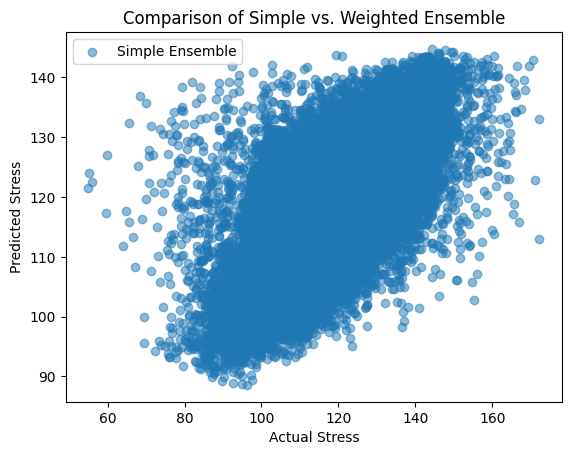

In [ ]:

plt.scatter(stress_actual, stress_pred_ensemble, alpha=0.5, label="Simple Ensemble")
plt.xlabel('Actual Stress')
plt.ylabel('Predicted Stress')
plt.title('Comparison of Simple vs. Weighted Ensemble')
plt.legend()
plt.show()


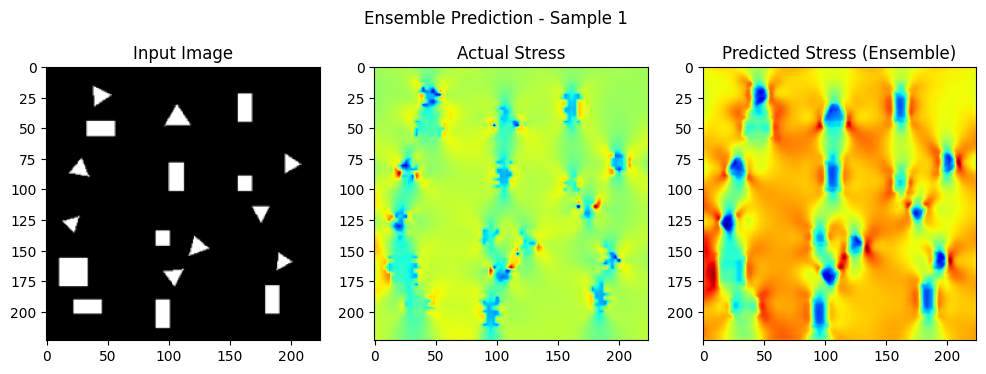

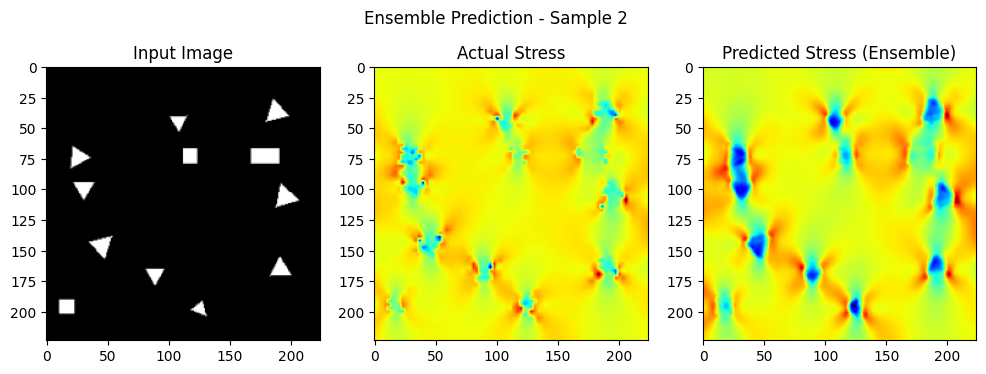

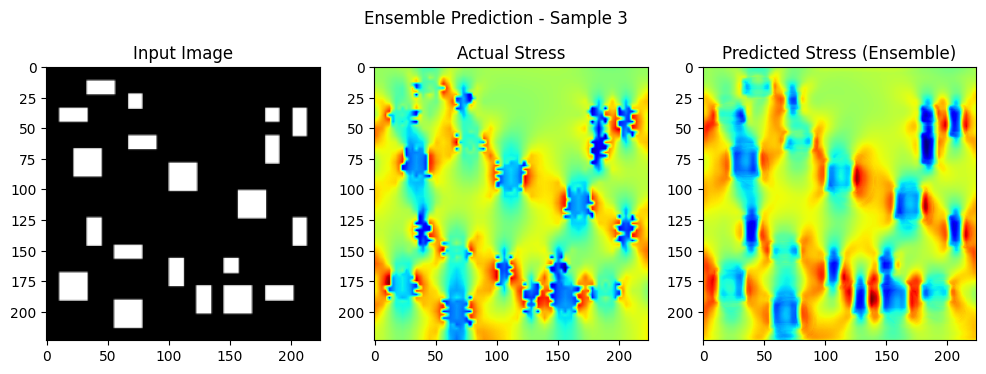

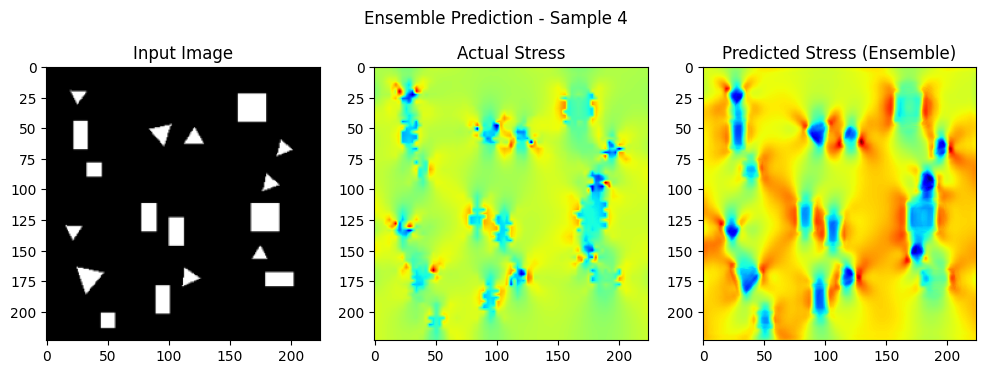

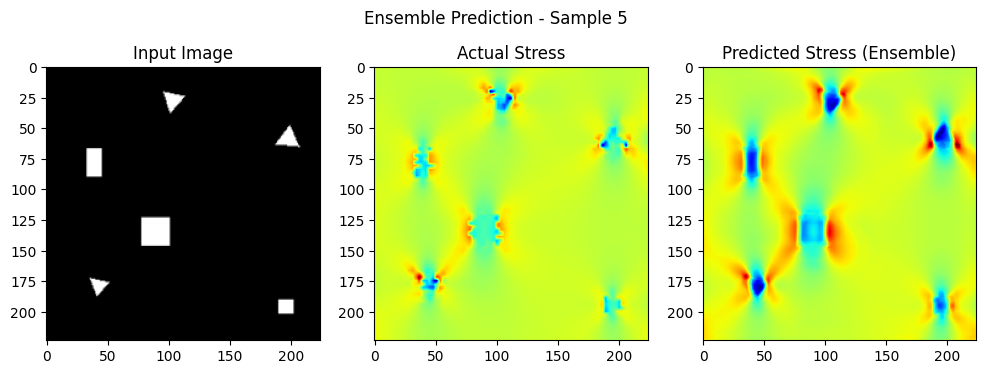

In [ ]:

# Loop through a few validation samples for visualization
for i in range(5):  # Show 5 random examples
    mask = val_dataset[i][0].unsqueeze(0).to(device)  # Input image
    output = val_dataset[i][1].unsqueeze(0).to(device)  # Actual stress map

    # Get ensemble prediction
    pred = ensemble_predict(models_unet, mask)  # Use simple averaging ensemble

    # Convert tensors to NumPy after moving to CPU
    mask_np = mask.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    output_np = output.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    pred_np = pred.squeeze()  # Remove extra dimensions from prediction

    # Plot 3x1 grid
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Ensemble Prediction - Sample {i+1}')

    axs[0].imshow(mask_np, cmap='gray')
    axs[0].set_title('Input Image')

    axs[1].imshow(output_np, cmap='jet')
    axs[1].set_title('Actual Stress')

    axs[2].imshow(pred_np, cmap='jet')  # Now correctly shaped (224, 224)
    axs[2].set_title('Predicted Stress (Ensemble)')

    plt.show()


In [24]:


# Load the validation dataset and evaluate ensemble performance
stress_actual = []
stress_pred_ensemble = []

for i, (mask, output) in enumerate(val_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mask = mask.unsqueeze(0).to(device)
    output = output.cpu().numpy().flatten()

    # Compute ensemble prediction (average of models)
    pred = ensemble_predict(models_unetpp, mask)
    pred = pred.flatten()

    stress_actual.extend(output)
    stress_pred_ensemble.extend(pred)


mae = mean_absolute_error(stress_actual, stress_pred_ensemble)
rmse = np.sqrt(mean_squared_error(stress_actual, stress_pred_ensemble))
r2 = r2_score(stress_actual, stress_pred_ensemble)

print(f"Ensemble U-Net++ Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


Ensemble U-Net++ Performance:
MAE: 1.4026, RMSE: 3.1401, R²: 0.7646


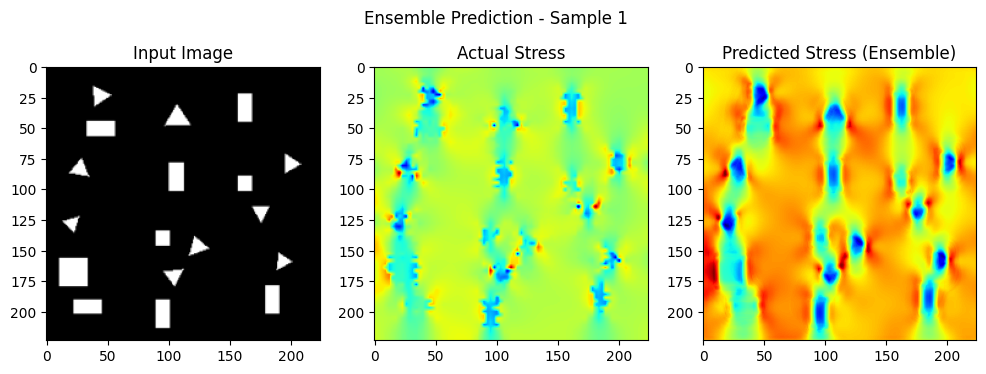

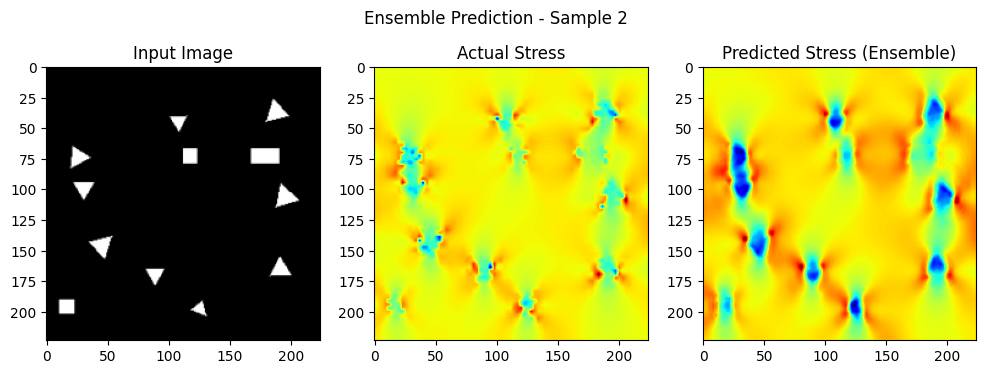

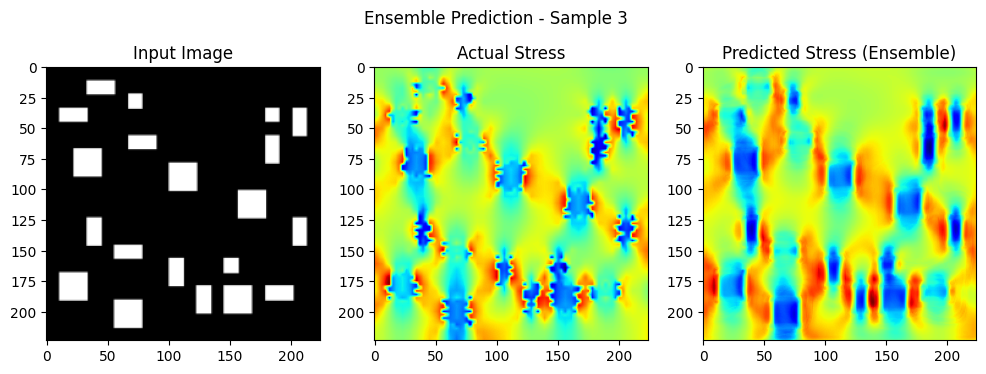

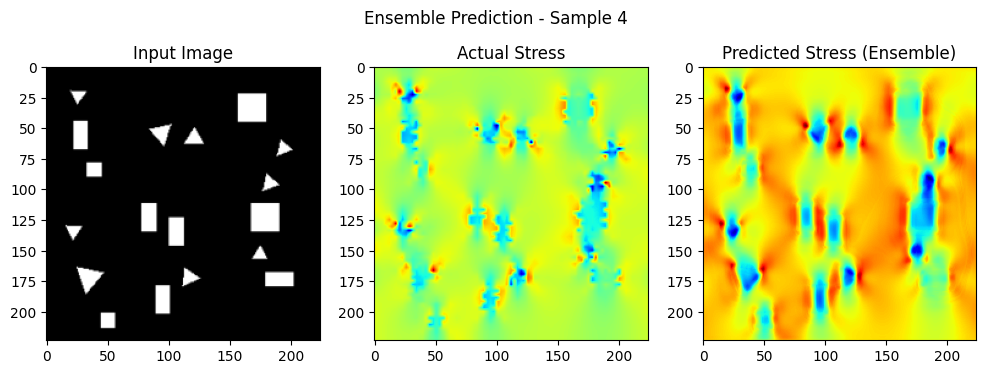

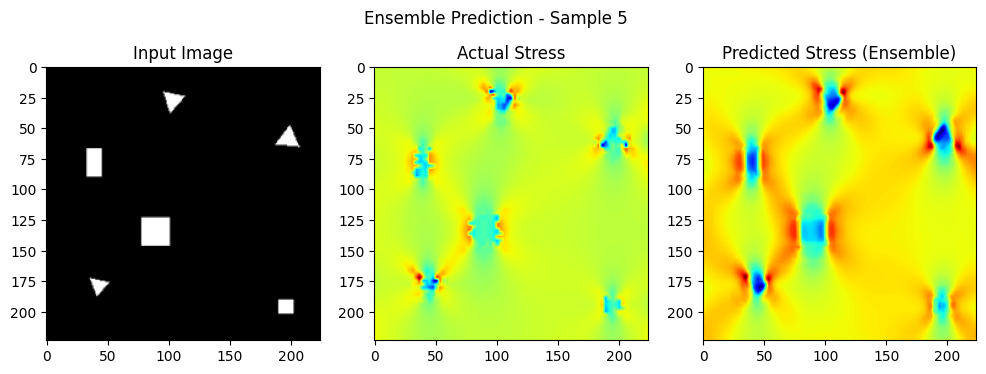

In [32]:

# Loop through a few validation samples for visualization
for i in range(5):  # Show 5 random examples
    mask = val_dataset[i][0].unsqueeze(0).to(device)  # Input image
    output = val_dataset[i][1].unsqueeze(0).to(device)  # Actual stress map

    # Get ensemble prediction
    pred = ensemble_predict(models_unetpp, mask)  # Use simple averaging ensemble

    # Convert tensors to NumPy after moving to CPU
    mask_np = mask.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    output_np = output.cpu().numpy().squeeze()  # Remove all unnecessary dimensions
    pred_np = pred.squeeze()  # Remove extra dimensions from prediction

    # Plot 3x1 grid
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Ensemble Prediction - Sample {i+1}')

    axs[0].imshow(mask_np, cmap='gray')
    axs[0].set_title('Input Image')

    axs[1].imshow(output_np, cmap='jet')
    axs[1].set_title('Actual Stress')

    axs[2].imshow(pred_np, cmap='jet')  # Now correctly shaped (224, 224)
    axs[2].set_title('Predicted Stress (Ensemble)')

    plt.show()
